# Building a Spotify Recommendation System. 

In this notebook we will se how to connect to spotify api to get playlists and extract necessary information from it and build a recommendation system to get similar songs.
<br>Process involved
<br>1.Connecting to Spotify API.
<BR>2.Vectorizing the playlist
<br>3.Building recommendation system

In [ ]:
!pip install spotipy

     |████████████████████████████████| 138 kB 11.3 MB/s 
     |████████████████████████████████| 62 kB 1.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import numpy as np
import time 
import datetime
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

from sklearn.pipeline import Pipeline
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from math import pi, ceil
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


In [ ]:
song_df=pd.read_csv("cleaned_data_spotify_final.csv")
song_df.drop('Unnamed: 0',axis=1,inplace=True)

In [ ]:
client_id = '7573e000a6a54da2acaef0edd94a3236'
client_secret ='632231db7c1244c88614a03b231691fa'


client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
spotify = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [ ]:
song_df

,index,valence,acousticness,year,artists,danceability,duration_ms,energy,instrumentalness,loudness,key,liveness,name,popularity,speechiness,tempo,A Minor,Ab Major,Ab Minor,B Major,B Minor,Bb Major,Bb Minor,C Major,C Minor,D Major,D Minor,Db Major,Db Minor,E Major,E Minor,Eb Major,Eb Minor,F Major,F Minor,F# Major,F# Minor,G Major,G Minor,1930s,1940s,1950s,1960s,1970s,1980s,1990s,2000s,2010s,2020s
0,0,0.688,0.33500,2021,Olivia Rodrigo,0.563,178146,0.664,0.000000,-5.044,9,0.0849,good 4 u,100,0.1540,166.928,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,0.758,0.29700,2021,Lil Nas X,0.610,137875,0.508,0.000000,-6.682,8,0.3840,MONTERO (Call Me By Your Name),98,0.1520,178.818,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2,0.483,0.01370,2020,MOMO Soundz,0.766,174392,0.718,0.003530,-6.270,11,0.1150,Down,57,0.0315,126.077,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,3,0.742,0.23500,2021,Doja Cat,0.762,208866,0.701,0.000158,-3.541,8,0.1230,Kiss Me More (feat. SZA),96,0.0286,110.968,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,4,0.589,0.12700,2017,Måneskin,0.714,211560,0.800,0.000000,-4.808,11,0.3590,Beggin',99,0.0504,134.002,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27230,171180,0.608,0.08460,2020,"['Anuel AA', 'Daddy Yankee', 'KAROL G', 'Ozuna...",0.786,301714,0.808,0.000289,-3.702,7,0.0822,China,72,0.0881,105.029,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
27231,171181,0.734,0.20600,2020,['Ashnikko'],0.717,150654,0.753,0.000000,-6.020,7,0.1010,Halloweenie III: Seven Days,68,0.0605,137.936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
27232,171182,0.637,0.10100,2020,['MAMAMOO'],0.634,211280,0.858,0.000009,-2.226,4,0.2580,AYA,76,0.0809,91.688,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
27233,171183,0.195,0.00998,2020,['Eminem'],0.671,337147,0.623,0.000008,-7.161,2,0.6430,Darkness,70,0.3080,75.055,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
song_df.isnull().sum()

index               0
valence             0
acousticness        0
year                0
artists             0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
loudness            0
key                 0
liveness            0
name                0
popularity          0
speechiness         0
tempo               0
A Minor             0
Ab Major            0
Ab Minor            0
B Major             0
B Minor             0
Bb Major            0
Bb Minor            0
C Major             0
C Minor             0
D Major             0
D Minor             0
Db Major            0
Db Minor            0
E Major             0
E Minor             0
Eb Major            0
Eb Minor            0
F Major             0
F Minor             0
F# Major            0
F# Minor            0
G Major             0
G Minor             0
1930s               0
1940s               0
1950s               0
1960s               0
1970s               0
1980s               0
1990s     

## 1. Connecting To Spotify API

In [ ]:

ids = []
def getTrackIDs(playlist_id):
    
    try:
        playlist = spotify.playlist(playlist_id)
    
        for item in playlist['tracks']['items']:
            track = item['track']
            if track is not None:
                ids.append(track['id'])
        return ids
    except:
        print("Entered a invalid a link")
        pass




In [ ]:

def getTrackFeatures(id_s):
    
    
   
    
    meta = spotify.track(id_s)
        # meta
    name = meta['name']

    artists = meta['album']['artists'][0]['name']
    release_date = meta['album']['release_date']
    duration_ms = meta['duration_ms']
    popularity = meta['popularity']
    explicit=meta['explicit']
    features = spotify.audio_features(tracks=id_s)
    tempo=features[0]['tempo']
    valence=features[0]['valence']
    acousticness = features[0]['acousticness']
    danceability = features[0]['danceability']
    energy = features[0]['energy']
    instrumentalness = features[0]['instrumentalness']
    liveness = features[0]['liveness']
    loudness = features[0]['loudness']
    speechiness = features[0]['speechiness']
    mode=features[0]['mode']
    key=features[0]['key']
    import datetime

    track = [valence, acousticness,artists,danceability,duration_ms,energy,explicit,id_s,instrumentalness,loudness,key,liveness,mode,name,popularity,release_date,speechiness,tempo]
    return track


tracks=[]
def get_playlist_df():

    ids = getTrackIDs(input("Enter a link to your playlist "))
    for i in range(len(ids)):
        time.sleep(.5)
        track = getTrackFeatures(ids[i])
        tracks.append(track)  
        


    playlist_df = pd.DataFrame(tracks, columns =  ["valence","acousticness","artists","danceability","duration_ms","energy","explicit","id","instrumentalness","loudness","key","liveness","mode","name","popularity","release_date","speechiness","tempo"])
    playlist_df['year'] = pd.DatetimeIndex(playlist_df['release_date']).year
    year =playlist_df['year']
    playlist_df.drop(labels=['year'], axis=1, inplace = True)
    playlist_df.insert(2, 'year', year)    
    return playlist_df



In [ ]:
playlist_df=get_playlist_df()

Enter a link to your playlist 56z43YN8tkXkoJFW529z2M


In [ ]:
playlist_df[['name','artists','valence', 'acousticness', 'instrumentalness', 'energy']]

,name,artists,valence,acousticness,instrumentalness,energy
0,Thunder,Imagine Dragons,0.288,0.00671,0.134000,0.822
1,More Than You Know,Axwell /\ Ingrosso,0.571,0.02750,0.000000,0.741
2,Whatever It Takes,Imagine Dragons,0.556,0.03620,0.000000,0.655
3,Natural,Imagine Dragons,0.220,0.21700,0.000000,0.611
4,Save Your Tears (with Ariana Grande) (Remix),The Weeknd,0.593,0.02150,0.000024,0.825
5,Beggin',Måneskin,0.589,0.12700,0.000000,0.800


In [ ]:
playlist_df.to_csv("playlist.csv")

### Deciding upon columns to include
<pre>valence: defines the mood of a song (e.g. happy, cheerful, euphoric, sad, depressed, angry).
danceability:How suitable is the track for dancing track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity.
instrumentalness:This value represents the amount of vocals in the song. The closer it is to 1.0, the more instrumental the song is.
and energy: measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
</pre>

these features seem to differentiate each song from the other so we consider these features for clustering our model

In [ ]:

columns_cluster = ['valence', 'acousticness','instrumentalness','energy']

### Standardizing the dataset
standardization is done using minmax method

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
ss = StandardScaler()

songs_scaled = ss.fit_transform(song_df[columns_cluster])


playlist_scaled = ss.fit_transform(playlist_df[columns_cluster])


In [ ]:
columns_to_cluster_scaled = [ 'valence_scaled','acousticness_scaled',"instrunentalness_scaled",'energy_scaled']

df_songs_scaled = pd.DataFrame(songs_scaled, columns=columns_to_cluster_scaled)
df_playlist_scaled = pd.DataFrame(playlist_scaled, columns=columns_to_cluster_scaled)
df_song_scaled_f=pd.concat([df_songs_scaled,song_df[['name','artists']]],axis=1)
df_playlist_scaled_f=pd.concat([df_playlist_scaled,playlist_df[['name','artists']]],axis=1)

In [ ]:
df_songs_scaled.isnull().sum()

valence_scaled             0
acousticness_scaled        0
instrunentalness_scaled    0
energy_scaled              0
dtype: int64

## Clustering the dataset

### Checking the which cluster value to choose

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
n_clusters = range(2,12)
ssd = []
sc = []


for n in n_clusters:
    km = KMeans(n_clusters=n, max_iter=500, n_init=10, init='k-means++', random_state=42)
    km.fit(songs_scaled)
    preds = km.predict(songs_scaled) 
    centers = km.cluster_centers_ 
    ssd.append(km.inertia_) 
    score = silhouette_score(songs_scaled, preds, metric='euclidean')
    sc.append(score)
    print("Number of Clusters = {}, Silhouette Score = {}".format(n, score))

Number of Clusters = 2, Silhouette Score = 0.40426554624212196
Number of Clusters = 3, Silhouette Score = 0.3815194994099475
Number of Clusters = 4, Silhouette Score = 0.32687363057813085
Number of Clusters = 5, Silhouette Score = 0.3106841694395596
Number of Clusters = 6, Silhouette Score = 0.32048496548673916
Number of Clusters = 7, Silhouette Score = 0.30343903635425257
Number of Clusters = 8, Silhouette Score = 0.2939430975381679
Number of Clusters = 9, Silhouette Score = 0.2855306283770438
Number of Clusters = 10, Silhouette Score = 0.28702275344055334
Number of Clusters = 11, Silhouette Score = 0.2711916072755785


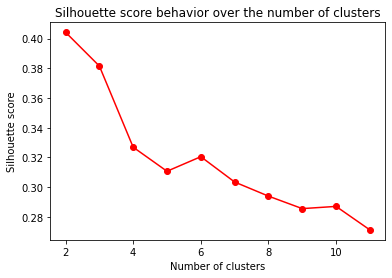

In [ ]:
plt.plot(n_clusters, sc, marker='.', markersize=12, color='red')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette score behavior over the number of clusters')
plt.show()



In [ ]:
for n, s in zip(n_clusters, ssd):
    print('Number of Clusters = {}, Sum of Squared Distances = {}'.format(n, s))

Number of Clusters = 2, Sum of Squared Distances = 72205.88764168439
Number of Clusters = 3, Sum of Squared Distances = 52325.36672503219
Number of Clusters = 4, Sum of Squared Distances = 39745.3474303937
Number of Clusters = 5, Sum of Squared Distances = 34559.66489452051
Number of Clusters = 6, Sum of Squared Distances = 29582.771971854112
Number of Clusters = 7, Sum of Squared Distances = 25618.87499568195
Number of Clusters = 8, Sum of Squared Distances = 23441.133045769187
Number of Clusters = 9, Sum of Squared Distances = 21730.98133633188
Number of Clusters = 10, Sum of Squared Distances = 20389.386092536966
Number of Clusters = 11, Sum of Squared Distances = 19186.65430772707


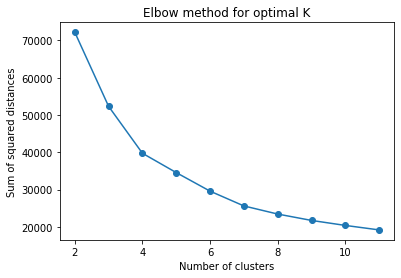

In [ ]:
plt.plot(n_clusters, ssd, marker='.', markersize=12)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow method for optimal K')
plt.show()


In [ ]:
k=6

model = KMeans(n_clusters=k, random_state=42).fit(songs_scaled)
pred = model.predict(songs_scaled)
print('10 first clusters: ', model.labels_[:10])

10 first clusters:  [3 3 4 1 1 1 4 3 1 1]


In [ ]:
model_playlist=KMeans(n_clusters=k, random_state=42).fit(playlist_scaled)
pred_playlist = model.predict(playlist_scaled)


no of songs per cluster

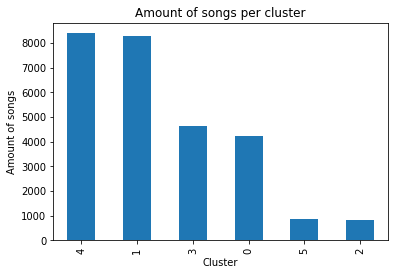

In [ ]:
df_songs_scaled['cluster'] = model.labels_

df_songs_scaled['cluster'].value_counts().plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Amount of songs')
plt.title('Amount of songs per cluster')
plt.show()

In [ ]:
c0 = df_songs_scaled[df_songs_scaled['cluster']==0]
c1 = df_songs_scaled[df_songs_scaled['cluster']==1]
c2 = df_songs_scaled[df_songs_scaled['cluster']==2]
c3 = df_songs_scaled[df_songs_scaled['cluster']==3]
c4 = df_songs_scaled[df_songs_scaled['cluster']==4]
c5 = df_songs_scaled[df_songs_scaled['cluster']==5]
c0

,valence_scaled,acousticness_scaled,instrunentalness_scaled,energy_scaled,cluster
26,-1.224515,2.285812,-0.300605,-1.524465,0
28,-0.919190,1.907231,-0.296257,-1.230245,0
44,-1.071852,2.378736,-0.272628,-1.180454,0
51,-1.087922,0.771488,-0.302407,-0.410957,0
54,-1.744370,1.304943,0.480170,-1.624047,0
...,...,...,...,...,...
27215,-0.625918,2.110288,-0.302417,-1.587835,0
27217,-1.405299,0.922920,-0.302417,-1.207613,0
27220,-1.196393,2.392503,-0.282676,-2.298489,0
27223,-1.288793,1.036495,-0.302417,-1.320774,0


In [ ]:
c0

,valence_scaled,acousticness_scaled,instrunentalness_scaled,energy_scaled,cluster
26,-1.224515,2.285812,-0.300605,-1.524465,0
28,-0.919190,1.907231,-0.296257,-1.230245,0
44,-1.071852,2.378736,-0.272628,-1.180454,0
51,-1.087922,0.771488,-0.302407,-0.410957,0
54,-1.744370,1.304943,0.480170,-1.624047,0
...,...,...,...,...,...
27215,-0.625918,2.110288,-0.302417,-1.587835,0
27217,-1.405299,0.922920,-0.302417,-1.207613,0
27220,-1.196393,2.392503,-0.282676,-2.298489,0
27223,-1.288793,1.036495,-0.302417,-1.320774,0


In [ ]:
c0.drop(['cluster'] ,axis=1,inplace=True)
c0=c0.melt(var_name='groups', value_name='vals')
c1.drop(['cluster'] ,axis=1,inplace=True)
c1=c1.melt(var_name='groups', value_name='vals')
c2.drop('cluster' ,axis=1,inplace=True)
c2=c2.melt(var_name='groups', value_name='vals')
c3.drop('cluster' ,axis=1,inplace=True)
c3=c3.melt(var_name='groups', value_name='vals')
c4.drop('cluster' ,axis=1,inplace=True)
c4=c4.melt(var_name='groups', value_name='vals')
c5.drop('cluster' ,axis=1,inplace=True)
c5=c5.melt(var_name='groups', value_name='vals')

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


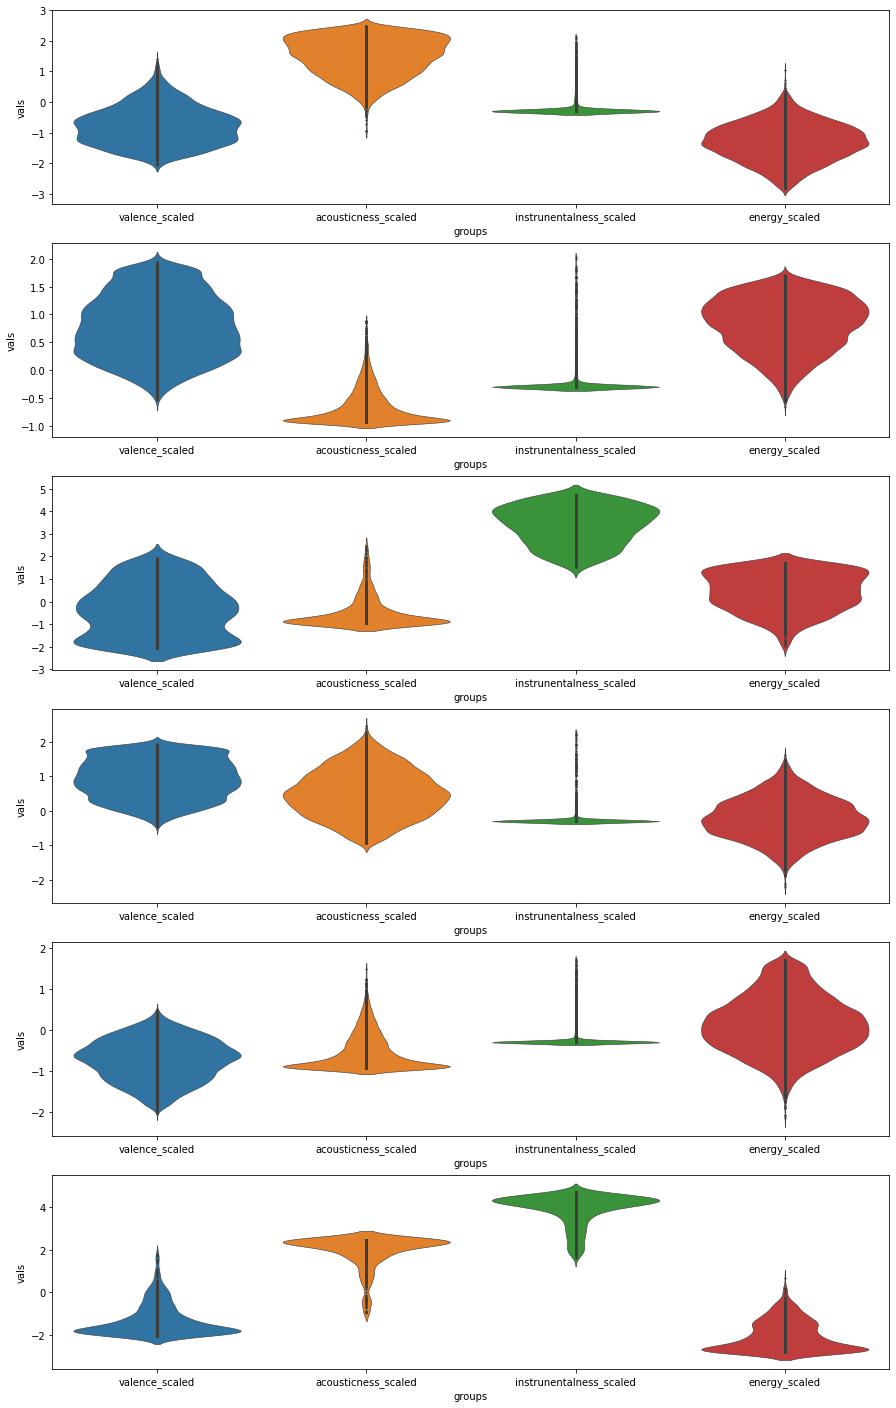

In [ ]:

f, axes = plt.subplots(6, 1,figsize=(15,25))

ax= sns.violinplot( data=c0 ,x="groups", y="vals", linewidth = 0.6, inner = 'point', scale= 'width', ax=axes[0])
ax = sns.violinplot( data=c1 ,x="groups", y="vals", linewidth = 0.6, inner = 'point', scale= 'width', ax=axes[1])
ax = sns.violinplot( data=c2 ,x="groups", y="vals", linewidth = 0.6, inner = 'point', scale= 'width', ax=axes[2])
ax = sns.violinplot( data=c3 ,x="groups", y="vals", linewidth = 0.6, inner = 'point', scale= 'width', ax=axes[3])
ax = sns.violinplot( data=c4 ,x="groups", y="vals", linewidth = 0.6, inner = 'point', scale= 'width', ax=axes[4])
ax = sns.violinplot( data=c5 ,x="groups", y="vals", linewidth = 0.6, inner = 'point', scale= 'width', ax=axes[5])

plt.show()

In [ ]:
display(df_songs_scaled['cluster'].value_counts())
minor_cluster = df_songs_scaled['cluster'].value_counts().tail(1)
print("Amount of songs in the smallest cluster: ", int(minor_cluster.values))


4    8393
1    8271
3    4621
0    4233
5     871
2     846
Name: cluster, dtype: int64

Amount of songs in the smallest cluster:  846


In [ ]:
df_songs_joined = pd.concat([song_df,df_songs_scaled], axis=1).set_index('cluster')

for cluster in range(k):
    display(df_songs_joined.loc[cluster, ['artists','name']].sample(frac=1).head(10))

,artists,name
cluster,,
0,['Jackson Browne'],Late for the Sky
0,['Amy Liz'],Slippery Fish
0,['Summer Salt'],Sweet to Me
0,['Trippie Redd'],Together
0,['Zach Bryan'],Letting Someone Go
0,"['Steven Universe', 'Deedee Magno Hall', 'Este...",Peace and Love on the Planet Earth (feat. Zach...
0,"['Adventure Time', 'Olivia Olson']",Everything Stays (feat. Olivia Olson)
0,['Gregory Alan Isakov'],Amsterdam
0,['Charlie Rich'],Behind Closed Doors


,artists,name
cluster,,
1,"['Don Omar', 'Mackie Ranks']",En Su Nota
1,['Hombres G'],Devuélveme a mi chica
1,"['Spencer Crandall', 'Julia Cole']",Things I Can't Say (feat. Julia Cole)
1,"[""Los Yonic's""]",Palabras Tristes
1,['Hanson'],MMMBop
1,['Lizzo'],Good as Hell
1,['Alan Jackson'],Chasin' That Neon Rainbow
1,"['Nicky Jam', 'Ozuna']",Te Robaré
1,['Del The Funky Homosapien'],Mistadobalina


,artists,name
cluster,,
2,['Rain Sounds Factory STHLM'],Rain Sound : Dark Sky
2,['Jimi Hendrix'],Hey Joe
2,['Radiohead'],The National Anthem
2,['Brian Tyler'],Iron Man 3
2,['ODESZA'],A Moment Apart
2,"['Calvin Harris', 'Kelis']",Bounce (feat. Kelis) - Radio Edit
2,['Wardruna'],Fehu
2,['Sound Library XL'],Calming Water
2,['AC/DC'],Sin City


,artists,name
cluster,,
3,"['Anuel AA', 'KAROL G']",Secreto
3,['LDNE'],Labios Rojos
3,['Vitas'],7 элемент
3,"['Free Nationals', 'Chronixx']",Eternal Light
3,HVME,Alright (feat. 24kGoldn & Quavo)
3,['TLC'],Waterfalls
3,['José Alfredo Jimenez'],Que Te Vaya Bonito
3,['Dead Horses'],Turntable
3,['Santana'],Oye Como Va


,artists,name
cluster,,
4,['Tori Kelly'],Dear No One
4,['Fleetwood Mac'],Silver Springs - 2004 Remaster
4,['Oasis'],Champagne Supernova
4,['Iamjakehill'],Die a King
4,['Cody Johnson'],With You I Am
4,['Lenny Kravitz'],Can't Get You Off My Mind
4,"['Alejandro Fernández', 'Christina Aguilera']",Hoy Tengo Ganas De Ti
4,"['Lil Durk', 'Lil Baby', 'Polo G']",3 Headed Goat (feat. Lil Baby & Polo G)
4,['Matt Redman'],"10,000 Reasons (Bless The Lord) [Radio Version..."


,artists,name
cluster,,
5,"['Benjy Wertheimer', 'John De Kadt']",One River
5,['Cigarettes After Sex'],Affection
5,"['Claude Debussy', 'Lavinia Meijer', 'Amsterda...","Dances for Harp and Orchestra, L. 103: 2. Dans..."
5,['Llusion'],walk but in a garden
5,['Václav Slezák'],Trpělivost růže přináší
5,['Michel LeBond'],Primordeal Instincts
5,['Deep Sleep Music Collective'],Purple Star
5,['Sufjan Stevens'],Futile Devices (Doveman Remix)
5,['August Wilhelmsson'],Somewhere In Between


In [ ]:

pca = PCA(n_components=3, random_state=0)
songs_pca = pca.fit_transform(songs_scaled)
pca.explained_variance_ratio_.sum()

0.9269998411293283

In [ ]:
df_pca = pd.DataFrame(songs_pca, columns=['C1', 'C2', 'C3'])
df_pca['cluster'] = model.labels_
df_pca.head()

,C1,C2,C3,cluster
0,-0.403860,-0.597870,0.399024,3
1,-0.160458,-0.883028,0.541851,3
2,-0.835013,0.394718,-0.409048,4
3,-0.791671,-0.493519,0.501253,1
4,-1.024221,0.107289,-0.004981,1


In [ ]:
sampled_clusters_pca = pd.DataFrame()

for c in df_pca.cluster.unique():
    df_cluster_sampled_pca = df_pca[df_pca.cluster == c].sample(n=int(minor_cluster), random_state=20)
    sampled_clusters_pca = pd.concat([sampled_clusters_pca,df_cluster_sampled_pca], axis=0)
sampled_clusters_pca.cluster.value_counts()

3    846
2    846
5    846
1    846
4    846
0    846
Name: cluster, dtype: int64

In [ ]:
def clusters_view_using_pca(data_graph):
  sns.scatterplot(x='C1', y='C2', hue='cluster', data=data_graph, legend="full", palette='Paired')
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  plt.title('Clusters view using PCA')
  plt.show()

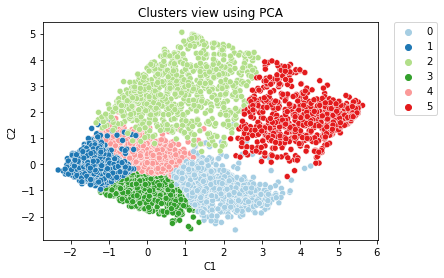

In [ ]:
clusters_view_using_pca(sampled_clusters_pca)

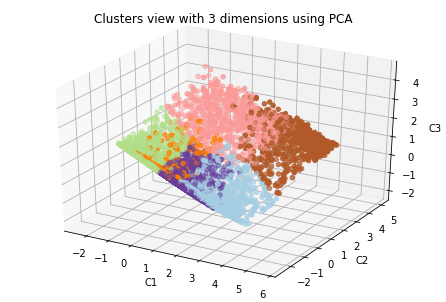

In [ ]:
fig = plt.figure()
fig.suptitle('Clusters view with 3 dimensions using PCA')
ax = Axes3D(fig)

ax.scatter(df_pca['C1'], df_pca['C2'], df_pca['C3'],
           c=df_pca['cluster'], cmap='Paired')

ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_zlabel('C3')
plt.show()

In [ ]:
tsne = TSNE(n_components=2, perplexity=50, random_state=42)
songs_tsne = tsne.fit_transform(songs_scaled)

In [ ]:
df_tsne = pd.DataFrame(songs_tsne, columns=['C1', 'C2'])
df_tsne['cluster'] = model.labels_
df_tsne.head()

,C1,C2,cluster
0,-10.075361,12.299200,3
1,-8.692796,37.337086,3
2,-15.671061,-34.538998,4
3,-14.605363,13.708733,1
4,-31.120131,-18.820791,1


In [ ]:
sampled_clusters_tsne = pd.DataFrame()

for c in df_tsne.cluster.unique():
    df_cluster_sampled_tsne = df_tsne[df_tsne.cluster == c].sample(n=int(minor_cluster), random_state=42)
    sampled_clusters_tsne = pd.concat([sampled_clusters_tsne,df_cluster_sampled_tsne], axis=0)
sampled_clusters_tsne.cluster.value_counts()

3    846
2    846
5    846
1    846
4    846
0    846
Name: cluster, dtype: int64

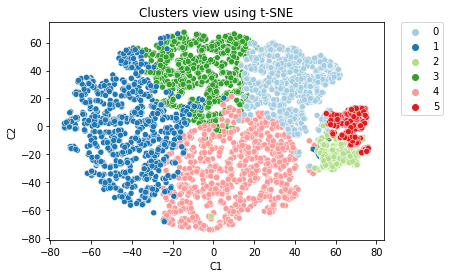

In [ ]:
sns.scatterplot(x='C1', y='C2', hue='cluster', data=sampled_clusters_tsne, legend="full", palette='Paired')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Clusters view using t-SNE')
plt.show()

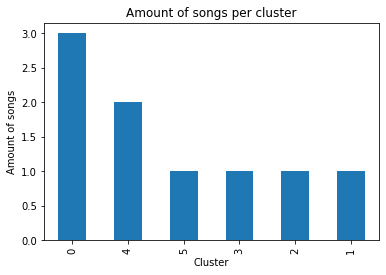

In [ ]:
df_playlist_scaled['cluster'] = model_playlist.labels_

df_playlist_scaled['cluster'].value_counts().plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Amount of songs')
plt.title('Amount of songs per cluster')
plt.show()

In [ ]:
songs_pca = pca.fit_transform(playlist_scaled)
pca.explained_variance_ratio_.sum()
df_playlist_pca = pd.DataFrame(songs_pca, columns=['C1', 'C2', 'C3'])
df_playlist_pca['cluster'] = model_playlist.labels_
df_playlist_pca

,C1,C2,C3,cluster
0,-1.325905,2.949344,0.772711,1
1,-0.488013,-0.714218,0.229606,0
2,0.169732,-0.873024,0.955429,0
3,3.143727,0.698019,0.065458,2
4,0.783940,0.740108,-1.108276,5
5,-1.426119,-0.372598,-0.716396,4
6,0.148347,-1.318138,1.141056,0
7,-1.123836,-0.588451,-0.486946,4
8,0.118128,-0.521042,-0.852641,3


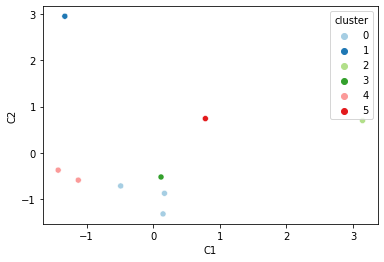

In [ ]:
sns.scatterplot(x='C1', y='C2', hue='cluster', data=df_playlist_pca, legend="full", palette='Paired')

In [ ]:
!pip install plotly

In [ ]:
df_playlist_scaled_f['playlist_track'] = 1

# drop unnecessary features



# label each label track as 0 in the playlist column
df_song_scaled_f['playlist_track'] = 0

In [ ]:
# create main dataframe using playlist songs and all label's songs, to be fed into model
main_df = pd.concat([df_playlist_scaled_f, df_song_scaled_f], axis=0).reset_index(drop=True)

# convert main dataframe to array
main_array = np.array(main_df.drop(['name', 'artists','playlist_track'], axis=1))

In [ ]:

k_means = KMeans(random_state=1, n_clusters=6) # default n_clusters = 8

# fit to data
k_means.fit(main_array)

# predict which clusters each song belongs too
predicted_clusters = k_means.fit_predict(main_array)

# each instance was assigned to one of the clusters

In [ ]:
print(predicted_clusters)


[2 1 0 ... 1 4 1]


In [ ]:
pred_series = pd.Series(predicted_clusters)
main_df_w_pred = pd.concat([main_df, pred_series], axis=1)
main_df_w_pred.rename(columns={0:'cluster'},inplace=True)

In [ ]:
main_df_w_pred.cluster.unique()

array([2, 1, 0, 3, 5, 4], dtype=int32)

In [ ]:
# look at the clusters most similar to user's playlist
relevant_clusters = main_df_w_pred['cluster'][main_df_w_pred.playlist_track==1]

# drop the user playlist songs from df, so they aren't recommended again
pred_df = main_df_w_pred.drop(main_df_w_pred[main_df_w_pred.playlist_track==1].index)

In [ ]:
pred_df

,valence_scaled,acousticness_scaled,instrunentalness_scaled,energy_scaled,name,artists,playlist_track,cluster
6,0.670021,0.241344,-0.291761,0.164143,good 4 u,Olivia Rodrigo,0,0
7,0.951852,0.108572,-0.291761,-0.547627,MONTERO (Call Me By Your Name),Lil Nas X,0,0
8,-0.155343,-0.881274,-0.272434,0.410525,Down,MOMO Soundz,0,5
9,0.887433,-0.108055,-0.290896,0.332960,Kiss Me More (feat. SZA),Doja Cat,0,1
10,0.271430,-0.485405,-0.291761,0.784660,Beggin',Måneskin,0,1
...,...,...,...,...,...,...,...,...
20313,-0.203657,-0.644731,-0.291761,0.784660,Chained To The Rhythm,"['Katy Perry', 'Skip Marley']",0,5
20314,-1.335009,2.456530,-0.291358,-2.473513,Places We Won't Walk,['Bruno Major'],0,3
20315,1.503436,-0.446971,-0.291761,0.967166,Cloudy Skies,['Lil Skies'],0,1
20316,-2.099980,2.260867,4.690503,-2.864695,White Noise - 700 hz,['Granular'],0,4


In [ ]:
relevant_clusters

0    2
1    1
2    0
3    3
4    1
5    0
Name: cluster, dtype: int32

In [ ]:
# return one random recommendation from each cluster
recs=[]
for k in relevant_clusters:
    recs +=pred_df[['name', 'artists']][pred_df.cluster==k].sample(1).values.tolist()
    pred_df.drop(pred_df[['name', 'artists']][pred_df.cluster==k].sample(1).index,inplace=True)

print(' similar to your playlist:\n')
for song in recs:
    print(song[0]+', by '+ song[1])

 similar to your playlist:

Bleed, by ['Meshuggah']
Good Lovin, by ['Ludacris', 'Miguel']
Toxic, by ['YoungBoy Never Broke Again']
Dead Inside (Interlude), by ['XXXTENTACION']
Warning, by ['Green Day']
I Can See Clearly Now, by ['Johnny Nash']


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
rec=[]
rec_track=[]
for song in recs:
  sd=spotify.search(song[0])
  uri=sd['tracks']['items'][0]["uri"]
  uri=uri.replace("spotify:track:","")
  track=getTrackFeatures(uri)
    
  rec_track.append(track)  
        


rec_df = pd.DataFrame(rec_track, columns =  ["valence","acousticness","artists","danceability","duration_ms","energy","explicit","id","instrumentalness","loudness","key","liveness","mode","name","popularity","release_date","speechiness","tempo"])
rec_df['year'] = pd.DatetimeIndex(playlist_df['release_date']).year
year= rec_df['year']
rec_df.drop(labels=['year'], axis=1, inplace = True)
rec_df.insert(2, 'year', year)    



In [ ]:
rec_df,names

,valence,acousticness,year,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,loudness,key,liveness,mode,name,popularity,release_date,speechiness,tempo
0,0.225,0.1880,2017,Leona Lewis,0.638,262466,0.6560,False,7wZUrN8oemZfsEd1CGkbXE,0.000000,-5.886,5,0.1460,1,Bleeding Love,75,2007,0.0357,104.036
1,0.589,0.2940,2017,Ludacris,0.619,223440,0.7540,True,3aeSTu6ejN2BU8YywEcHWO,0.000003,-5.231,0,0.1090,1,Good Lovin,56,2015-03-31,0.2320,83.464
2,0.924,0.0249,2017,Britney Spears,0.774,198800,0.8380,False,6I9VzXrHxO9rA9A5euc8Ak,0.025000,-3.914,5,0.2420,0,Toxic,81,2003-11-13,0.1140,143.040
3,0.354,0.9730,2018,XXXTENTACION,0.461,86826,0.0279,True,2vQwlW8H1jFveGNXwZfJCV,0.002260,-21.992,0,0.1690,1,Dead Inside (Interlude),62,2017-08-25,0.0412,88.388
4,0.268,0.4600,2021,Morgan Wallen,0.633,156746,0.6640,False,64SCQtbRtmO28ks1QhS3w5,0.000000,-5.037,10,0.1080,1,Warning,68,2021-01-08,0.0294,115.058
5,0.623,0.6330,2017,Johnny Nash,0.681,164733,0.3730,False,0DcrhZ12WcCqruCs8ibXSf,0.001130,-13.200,2,0.0751,1,I Can See Clearly Now - Edit,68,1972,0.0568,123.423


In [ ]:
rec_df.to_csv("rec_songs.csv")

In [ ]:
from spotipy.oauth2 import SpotifyOAuth
from spotipy.oauth2 import SpotifyClientCredentials


In [ ]:
scope = "user-library-read playlist-modify-public"
OAuth = SpotifyOAuth(
        scope=scope,         
        redirect_uri='https://colab.research.google.com/drive/1lV6loJctbZydzo4JLNuaeAhxSLpULMKo#scrollTo=UcNlkqM4lCsx',
        client_id = '7573e000a6a54da2acaef0edd94a3236',
        client_secret ='632231db7c1244c88614a03b231691fa',
        username= 'Diya')